Python Notebook for Time Series Preprocessing
1. Setup and Data Loading
This section imports necessary libraries and loads your retail dataset.

In [7]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Set plotting style (optional)
plt.style.use('fivethirtyeight')

# --- 1. Load Data ---
# Assuming the file is 'sample_101_new_retail_data.csv' in the same directory
try:
    df = pd.read_csv('../data/raw/data.csv')
    print("Data loaded successfully.")
except FileNotFoundError:
    print("Error: The file 'sample_101_new_retail_data.csv' was not found.")
    df = None

# Columns identified for time-series analysis: 'Date' and 'Total_Amount'
DATE_COL = 'Date'
SALES_COL = 'Total_Amount'

if df is not None:
    print(f"\nOriginal shape: {df.shape}")

Data loaded successfully.

Original shape: (302010, 30)


2. Data Cleaning and Date Conversion

2.1 Handle Duplicates

Before aggregating, we remove exact duplicate transaction rows. This is important to ensure each record is unique.

In [8]:
if df is not None:
    # Check for duplicates
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    rows_removed = initial_rows - len(df)
    
    print(f"Removed {rows_removed} duplicate rows.")
    print(f"New shape: {df.shape}")

Removed 4 duplicate rows.
New shape: (302006, 30)


2.2 Convert Dates to Datetime

Convert the date column to the datetime format, which is essential for any time-series operation like resampling.

In [9]:
if df is not None:
    # Convert the date column to datetime objects
    df[DATE_COL] = pd.to_datetime(df[DATE_COL], errors='coerce')
    
    # Drop rows where date conversion failed (if any)
    df.dropna(subset=[DATE_COL], inplace=True)
    
    print(f"\n'{DATE_COL}' column converted to datetime.")
    print(df[DATE_COL].head())


'Date' column converted to datetime.
0   2023-09-18
1   2023-12-31
2   2023-04-26
3   2023-05-08
4   2024-01-10
Name: Date, dtype: datetime64[ns]


3. Resampling and Missing Data Imputation

We create the core time series by setting the date as the index, aggregating (summing) the sales for identical dates, and then resampling to different frequencies, imputing missing dates with zero sales.


--- Daily Sales Time Series (Imputed Missing Days with 0) ---
Date
2023-03-01    1.104406e+06
2023-03-02    1.121526e+06
2023-03-03    1.097523e+06
2023-03-04    1.084541e+06
2023-03-05    1.156682e+06
Freq: D, Name: Total_Amount, dtype: float64
Total days in series: 366

--- Weekly Sales Time Series ---
Date
2023-03-05    5.564677e+06
2023-03-12    8.059301e+06
2023-03-19    7.987902e+06
2023-03-26    7.760321e+06
2023-04-02    8.033403e+06
Freq: W-SUN, Name: Total_Amount, dtype: float64

--- Monthly Sales Time Series ---
Date
2023-03-31    3.522103e+07
2023-04-30    3.401264e+07
2023-05-31    3.447172e+07
2023-06-30    3.373023e+07
2023-07-31    3.484355e+07
Freq: ME, Name: Total_Amount, dtype: float64


C:\Users\udaya\AppData\Local\Temp\ipykernel_14844\3112208015.py:21: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales_ts = daily_sales_ts.resample('M').sum()


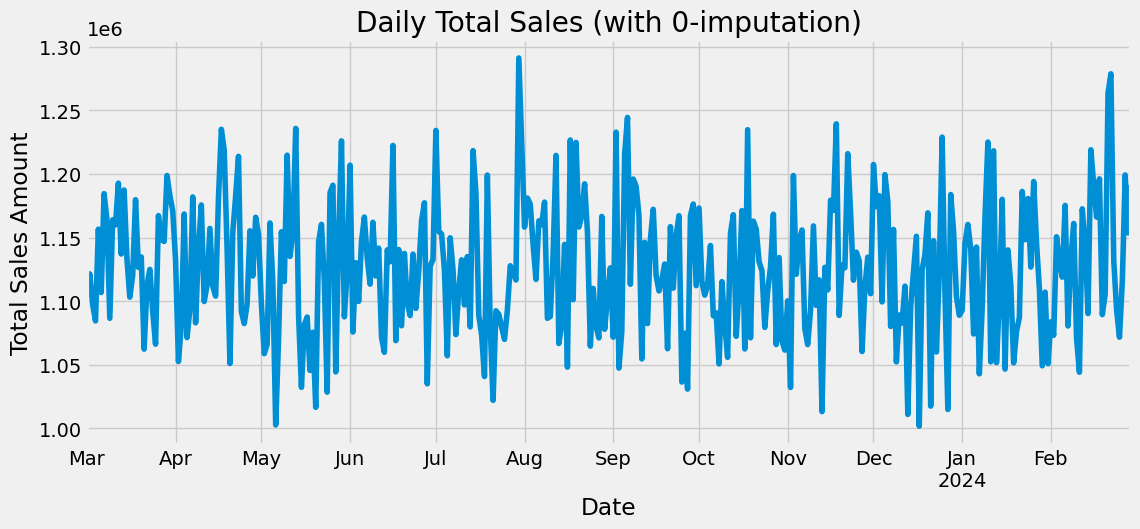

In [10]:
if df is not None:
    # Select only the relevant columns and aggregate sales by date
    daily_sales = df.set_index(DATE_COL)[SALES_COL].resample('D').sum()
    
    # --- Handle Missing Dates (Impute 0 Sales) ---
    # Fill any missing days (or other resampled periods) with 0 sales
    daily_sales_ts = daily_sales.fillna(0)
    
    print("\n--- Daily Sales Time Series (Imputed Missing Days with 0) ---")
    print(daily_sales_ts.head())
    print(f"Total days in series: {len(daily_sales_ts)}")

    # --- Resample by Weekly and Monthly Sales ---
    
    # 'W' for Weekly frequency
    weekly_sales_ts = daily_sales_ts.resample('W').sum()
    print("\n--- Weekly Sales Time Series ---")
    print(weekly_sales_ts.head())

    # 'M' for Monthly frequency (start of the month)
    monthly_sales_ts = daily_sales_ts.resample('M').sum()
    print("\n--- Monthly Sales Time Series ---")
    print(monthly_sales_ts.head())

    # Plot the daily sales
    plt.figure(figsize=(12, 5))
    daily_sales_ts.plot(title='Daily Total Sales (with 0-imputation)')
    plt.xlabel('Date')
    plt.ylabel('Total Sales Amount')
    plt.show()

4. Normalization

Normalization (using MinMaxScaler) scales the sales data to a small, specific range, typically [0, 1]. This is crucial for many machine learning models. We will apply this to the daily sales time series.


--- Normalized Daily Sales Time Series (MinMaxScaler) ---
Date
2023-03-01    0.354451
2023-03-02    0.413591
2023-03-03    0.330674
2023-03-04    0.285828
2023-03-05    0.535036
Freq: D, dtype: float64


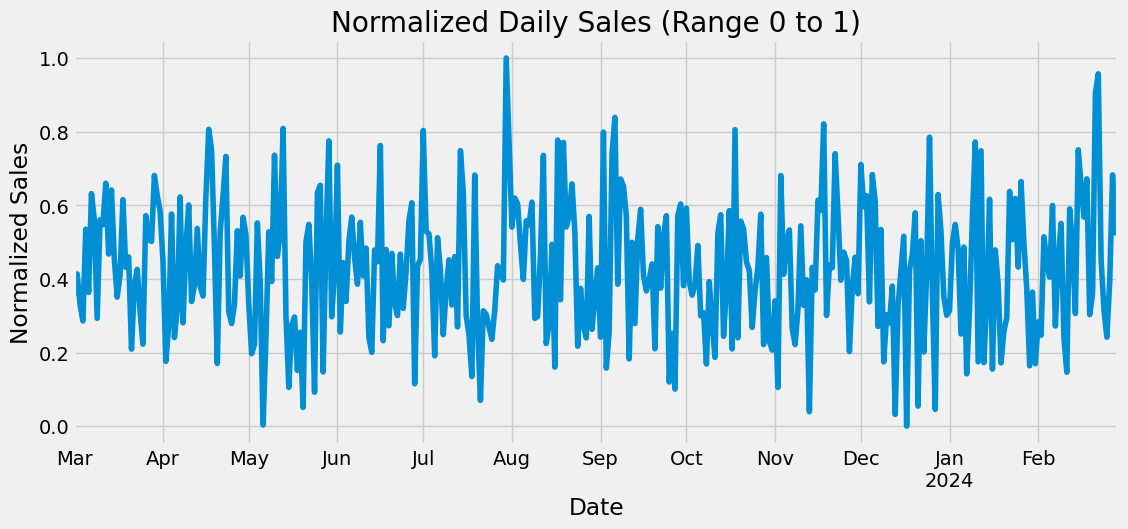

In [11]:
if df is not None:
    # Initialize the MinMaxScaler
    scaler = MinMaxScaler()
    
    # Reshape the data for the scaler (required for single feature)
    sales_array = daily_sales_ts.values.reshape(-1, 1)
    
    # Apply normalization
    sales_normalized = scaler.fit_transform(sales_array)
    
    # Convert back to a pandas Series with the original index
    daily_sales_normalized = pd.Series(sales_normalized.flatten(), index=daily_sales_ts.index)
    
    print("\n--- Normalized Daily Sales Time Series (MinMaxScaler) ---")
    print(daily_sales_normalized.head())

    # Plot the normalized sales
    plt.figure(figsize=(12, 5))
    daily_sales_normalized.plot(title='Normalized Daily Sales (Range 0 to 1)')
    plt.xlabel('Date')
    plt.ylabel('Normalized Sales')
    plt.show()


5. Trend and Seasonality Decomposition

Decomposition breaks down the time series into three components: Trend, Seasonality, and Residuals (or noise). We'll use the multiplicative model, which is often a good default for sales data.


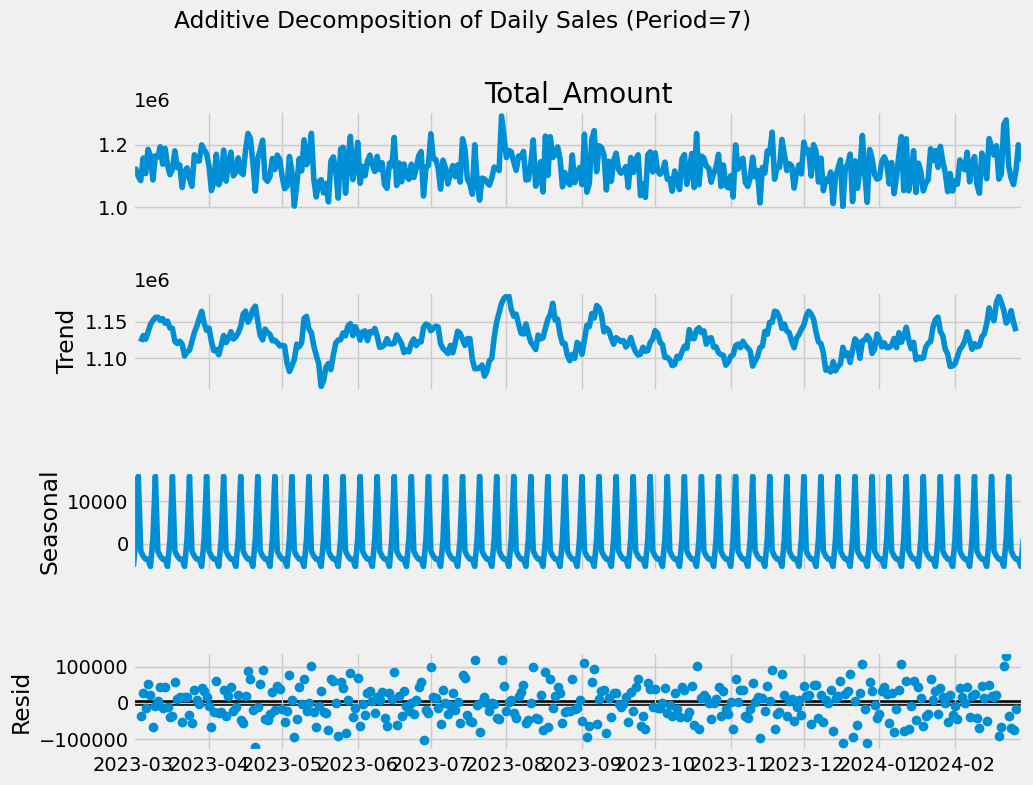


--- Decomposition Components ---
Trend (Head):
 Date
2023-03-04    1.122318e+06
2023-03-05    1.130847e+06
2023-03-06    1.125858e+06
2023-03-07    1.135362e+06
2023-03-08    1.146162e+06
Freq: D, Name: trend, dtype: float64
Seasonality (Head):
 Date
2023-03-01    -5295.271504
2023-03-02     1188.761745
2023-03-03    15809.354734
2023-03-04    -1681.802632
2023-03-05    -2857.201440
Freq: D, Name: seasonal, dtype: float64
Residuals (Head):
 Date
2023-03-04   -36095.580180
2023-03-05    28692.259358
2023-03-06   -15354.525268
2023-03-07    52847.173263
2023-03-08    23241.138233
Freq: D, Name: resid, dtype: float64


In [12]:
if df is not None:
    # Decomposition requires at least two full cycles. 
    # For daily data, a weekly seasonality (period=7) is common.
    # Check if we have enough data points for decomposition
    if len(daily_sales_ts) >= 14: # Check for at least two periods of 7
        
        # Apply additive decomposition
        # (Use 'multiplicative' if seasonality magnitude increases with the trend)
        decomposition = seasonal_decompose(daily_sales_ts, model='additive', period=7)
        
        # Plot the decomposition
        fig = decomposition.plot()
        fig.set_size_inches(12, 8)
        fig.suptitle('Additive Decomposition of Daily Sales (Period=7)', y=1.02)
        plt.show()

        # Extract the components
        trend = decomposition.trend
        seasonality = decomposition.seasonal
        residual = decomposition.resid
        
        print("\n--- Decomposition Components ---")
        print("Trend (Head):\n", trend.dropna().head())
        print("Seasonality (Head):\n", seasonality.dropna().head())
        print("Residuals (Head):\n", residual.dropna().head())
    
    else:
        print("\nNot enough data points to perform decomposition with a period of 7.")
        print(f"Data length: {len(daily_sales_ts)}")
